### Playback walk motion

In [1]:
import time,pickle,mujoco
import numpy as np
import cv2,glob,os
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists,r2rpy,quat2r,slerp,get_A_vel_acc_jerk,t2pr,r2quat
import mediapy as media

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse

In [2]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='MyoSuite',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
print ("Done.")

Done.


In [3]:
for idx, name in enumerate(env.body_names):
    print(idx, name)

0 world
1 base
2 root
3 spine1
4 spine2
5 spine3
6 neck
7 head
8 left_collar
9 left_shoulder
10 left_elbow
11 left_wrist
12 left_index1
13 left_index2
14 left_index3
15 left_index4
16 left_middle1
17 left_middle2
18 left_middle3
19 left_middle4
20 left_ring1
21 left_ring2
22 left_ring3
23 left_ring4
24 left_pinky1
25 left_pinky2
26 left_pinky3
27 left_pinky4
28 left_thumb1
29 left_thumb2
30 left_thumb3
31 left_thumb4
32 right_collar
33 right_shoulder
34 right_elbow
35 right_wrist
36 right_index1
37 right_index2
38 right_index3
39 right_index4
40 right_middle1
41 right_middle2
42 right_middle3
43 right_middle4
44 right_ring1
45 right_ring2
46 right_ring3
47 right_ring4
48 right_pinky1
49 right_pinky2
50 right_pinky3
51 right_pinky4
52 right_thumb1
53 right_thumb2
54 right_thumb3
55 right_thumb4
56 left_pelvis
57 left_knee
58 left_ankle
59 right_pelvis
60 right_knee
61 right_ankle


### Load walking motion

In [4]:
pkl_path = '../data/smpl walk mpc zpos edited.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)
# print(data.keys())
T_roots         = data['T_root'] # [L * 4 * 4]
qs    = data['q_rev'] # [L * Nj]
L = data['length']
print ("[%s] loaded."%(pkl_path))

KeyError: 'T_root'

### Extended Ground Truth Created

In [5]:
xpos = np.empty((L,env.n_body,3))
temp_rpy_roots = np.empty((L,3))
quat_joints = np.empty((L,env.n_body,4))
phase = 0
p_root, R_root = t2pr(T_roots)
quat_root = r2quat(R_root)# quaternion

temp_rpy_roots = [r2rpy(R) for R in R_root]

# create joint velocity and root's velocity, angular velocity
A_vel,A_acc,A_jerk = get_A_vel_acc_jerk(n=L,dt=1/120)
qvel = A_vel @ qs
vel_roots = A_vel @ p_root
ang_vel_roots = A_vel @ temp_rpy_roots

print("Extended Ground Truth Created")

Extended Ground Truth Created


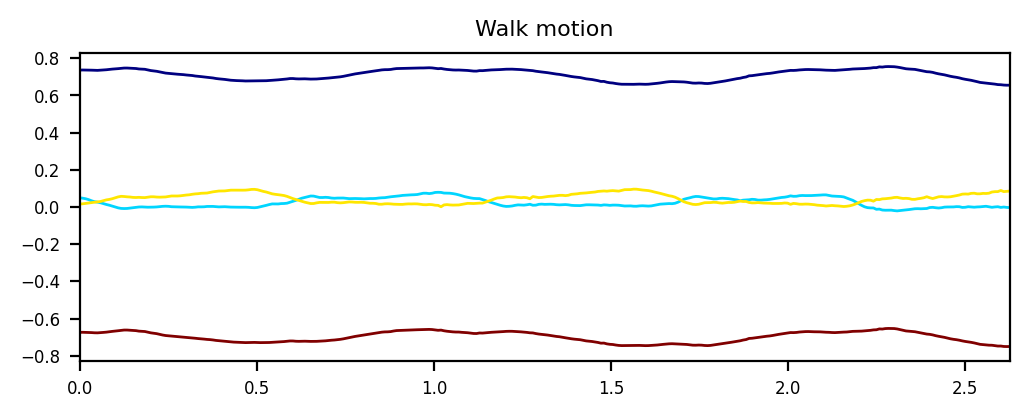

In [6]:
new_times = np.linspace(0,L/120,L)
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,quat_root.shape[1]))
for i_idx in range(quat_root.shape[1]):
    plt.plot(new_times,quat_root[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([new_times[0],new_times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

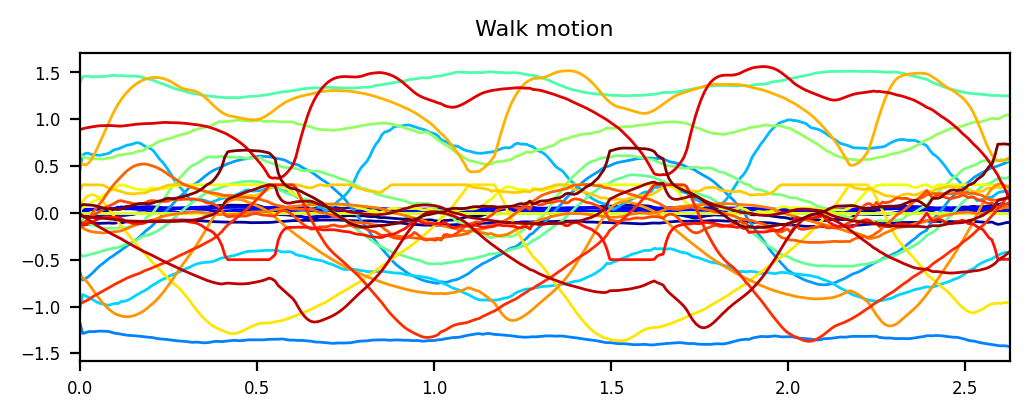

In [7]:
times = np.linspace(0,L/120,L)
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in range(qs.shape[1]):
    plt.plot(times,qs[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([times[0],times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

In [8]:
# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=rev_joint_names)
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

In [9]:
# n_rev_joint
np.concatenate((env.rev_joint_mins,env.pri_joint_mins)).shape

(37,)

In [10]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = False
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[0]


### Loop

In [11]:
p_root

array([[ 0.51,  1.73,  0.83],
       [ 0.51,  1.71,  0.84],
       [ 0.51,  1.7 ,  0.84],
       [ 0.51,  1.69,  0.84],
       [ 0.51,  1.68,  0.84],
       [ 0.5 ,  1.66,  0.84],
       [ 0.5 ,  1.65,  0.85],
       [ 0.5 ,  1.64,  0.85],
       [ 0.5 ,  1.63,  0.85],
       [ 0.5 ,  1.62,  0.85],
       [ 0.5 ,  1.61,  0.85],
       [ 0.5 ,  1.59,  0.85],
       [ 0.49,  1.58,  0.85],
       [ 0.49,  1.57,  0.86],
       [ 0.49,  1.56,  0.86],
       [ 0.49,  1.55,  0.86],
       [ 0.49,  1.54,  0.86],
       [ 0.49,  1.53,  0.86],
       [ 0.49,  1.52,  0.86],
       [ 0.49,  1.51,  0.86],
       [ 0.49,  1.5 ,  0.86],
       [ 0.49,  1.49,  0.86],
       [ 0.49,  1.48,  0.86],
       [ 0.49,  1.47,  0.85],
       [ 0.49,  1.45,  0.85],
       [ 0.49,  1.44,  0.85],
       [ 0.49,  1.43,  0.85],
       [ 0.49,  1.42,  0.85],
       [ 0.48,  1.41,  0.85],
       [ 0.48,  1.4 ,  0.85],
       [ 0.48,  1.39,  0.85],
       [ 0.48,  1.38,  0.85],
       [ 0.48,  1.37,  0.84],
       [ 0

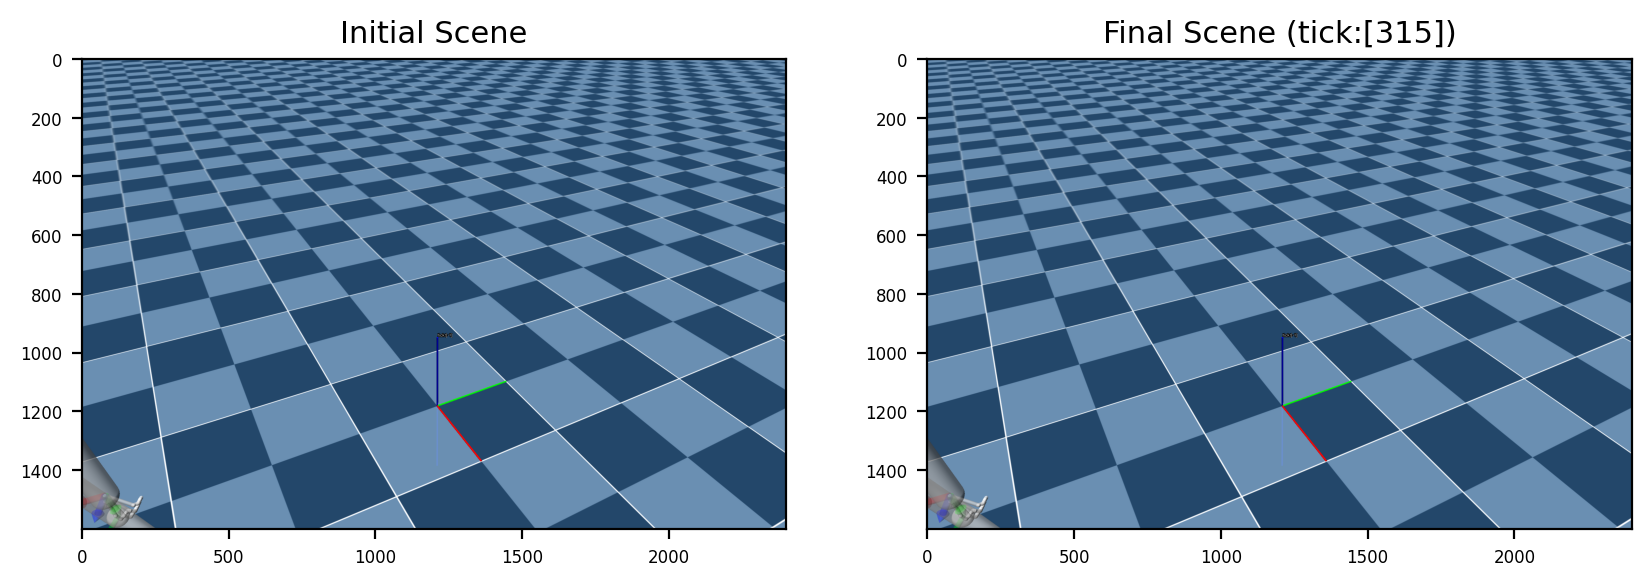

Done.


In [12]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='MyoSuite',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()
FIRST_FLAG = True
tick = 0
while env.tick < L:

    # Update
    time.sleep(1e-10) # little delay helps
    tick = (env.tick-1)
    # contact_in_tick = False

    # FK
    q    = qs[tick,:] # [37]
    p    = p_root[tick,:] # [3]
    quat = quat_root[tick,:] # [4] quaternion
    env.set_p_root(root_name='base',p=p)
    env.set_quat_root(root_name='base',quat=quat)
    # env.set_quat_root(root_name='base',quat=)
    env.forward(q=q,joint_idxs=joint_idxs_fwd)
        
    # Render
    quat_joints[tick]=r2quat(env.data.xmat.reshape(-1, 3, 3))
    xpos[tick]=env.data.xpos
    if env.loop_every(tick_every=1):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]"%(tick))
        # Plot foot
        # env.plot_geom_T(geom_name='foot2_right',axis_len=0.3)
        # env.plot_geom_T(geom_name='foot2_left',axis_len=0.3)
        # Plot revolute joints with arrow
        env.plot_joint_axis(axis_len=0.1,axis_r=0.01)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
        scene_img_final = scene_img_init.copy()
        FIRST_FLAG = False
    # if env.is_viewer_alive() and env.loop_every(tick_every=1000):
    #     scene_img_final = env.grab_image()

    if SAVE_VID:
        # Save iamges
        png_path = '../temp/cmu_smplrig_walk_%05d.png'%(env.tick)
        create_folder_if_not_exists(png_path)
        image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
        cv2.imwrite(png_path,image)
    
    # print("timestep {}".format(env.tick))

    
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()
print ("Done.")

In [13]:
assert L == p_root.shape[0]
assert L == R_root.shape[0]
assert L == qs.shape[0]
assert L == qvel.shape[0]
assert L == xpos.shape[0]
assert L == quat_joints.shape[0]

pkl_data = {
    'length': L,
    'p_root': p_root, # Z-position edited
    'R_root': quat_root,
    'v_root': vel_roots,
    'w_root': ang_vel_roots,
    'qpos': qs,
    'qvel': qvel,
    'xpos': xpos,
    'rotation': quat_joints,# Quaternion
}
with open('../data/smplrig_cmu_walk_optimized_recon.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)


In [15]:
quat_root

array([[ 0.74,  0.05,  0.02, -0.67],
       [ 0.74,  0.05,  0.02, -0.67],
       [ 0.74,  0.04,  0.02, -0.67],
       ...,
       [ 0.66, -0.  ,  0.08, -0.75],
       [ 0.66, -0.  ,  0.08, -0.75],
       [ 0.66, -0.  ,  0.09, -0.75]])